In [1]:
# make the imports that are necessary for our work
import qiskit as qk
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute, Aer
from qiskit import IBMQ
from qiskit.tools.visualization import plot_histogram

In [2]:
#Step 1: Alice and Bob create an entangled pair of qubits 
#and each one of them holds on to one of the two qubits in the pair.

#The pair they create is a special pair called a Bell pair. 
#In quantum circuit language, the way to create a Bell pair between two qubits is to first transfer 
#one of them to the Bell basis ( |+⟩  and  |−⟩ ) by using a Hadamard gate, 
#and then to apply a CNOT gate onto the other qubit controlled by the one in the Bell basis.

#Let's say Alice owns  q1  and Bob owns  q2  after they part ways.

#Step 2: Alice applies a CNOT gate on  q1 , controlled by  |ψ⟩  (the qubit she is trying to send Bob).

#Step 3: Next, Alice applies a Hadamard gate to  |ψ⟩ , and applies a measurement
#to both qubits that she owns -  q1  and  |ψ⟩ .

#Step 4: Then, it's time for a phone call to Bob. 
#She tells Bob the outcome of her two qubit measurement. 
#Depending on what she says, Bob applies some gates to his qubit,  q2 . 
#The gates to be applied, based on what Alice says, are as follows :

#00  →  Do nothing (Identity Gate)

#01  →  Apply  X  gate

#10  →  Apply  Z  gate

#11  →  Apply  ZX  gate

#Note that this transfer of information is classical.

#And voila! At the end of this protocol, Alice's qubit has now teleported to Bob.

In [3]:
# simple function that applies a series of unitary gates from a given string
def apply_secret_unitary(secret_unitary, qubit, quantum_circuit, dagger):
    functionmap = {
                    'x':quantum_circuit.x, #add x gate to quantum circuit
                    'y':quantum_circuit.y, #add y gate to quantum circuit
                    'z':quantum_circuit.z, #add z gate to quantum circuit
                    'h':quantum_circuit.h, #add h gate to quantum cicruit                   
                    't':quantum_circuit.t, #add t gate to quantum circuit                   
    }
    if dagger: functionmap['t'] = quantum_circuit.tdg #if dagger, apply tdg gate
    
    if dagger:
        [functionmap[unitary](qubit) for unitary in secret_unitary] #apply to function to qbit
    else:
        [functionmap[unitary](qubit) for unitary in secret_unitary[::-1]] #apply inverse function to qbit

In [4]:
secret_unitary = 'hz'

In [14]:
# Create the quantum circuit
q = QuantumRegister(3) #3 qbits
c = ClassicalRegister(3) #3 clasical bit
qc = QuantumCircuit(q, c) #add them qbits to the classical bits

''' Qubit ordering as follows (classical registers will just contain measured values of the corresponding qubits):
q[0]: qubit to be teleported (Alice's first qubit. It was given to her after the application of a secret unitary 
      which she doesn't know)
q[1]: Alice's second qubit
q[2]: Bob's qubit, which will be the destination for the teleportation
'''

# Apply the secret unitary that we are using to generate the state to teleport. You can change it to any unitary
qc.x(q[0]) #use this line to make alice''s qbit 1
apply_secret_unitary(secret_unitary, q[0], qc, dagger = 0)
qc.barrier()
# Next, generate the entangled pair between Alice and Bob (Remember: Hadamard followed by CX generates a Bell pair)
qc.h(q[1])
qc.cx(q[1], q[2])
qc.barrier()
# Next, apply the teleportation protocol. 
qc.cx(q[0], q[1])
qc.h(q[0])
qc.measure(q[0], c[0])
qc.measure(q[1], c[1])
qc.cx(q[1], q[2])
qc.cz(q[0], q[2])
qc.barrier()

'''
In principle, if the teleportation protocol worked, we have q[2] = secret_unitary|0>
As a result, we should be able to recover q[2] = |0> by applying the reverse of secret_unitary
since for a unitary u, u^dagger u = I.
'''
apply_secret_unitary(secret_unitary, q[2], qc, dagger=1)
qc.measure(q[2], c[2])

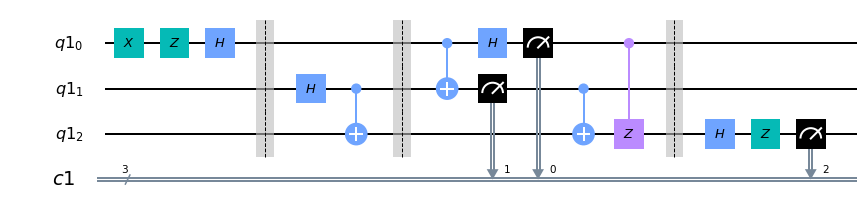

In [15]:
qc.draw(output='mpl')

{'110': 24951, '101': 25035, '100': 25104, '111': 24934}


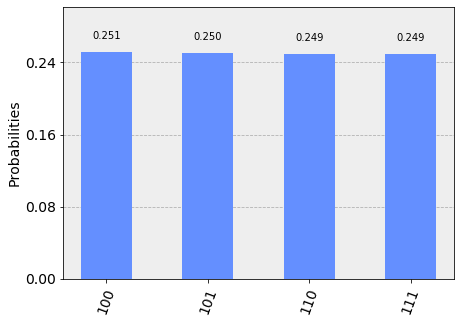

In [16]:
backend = Aer.get_backend('qasm_simulator')
job_sim = execute(qc, backend, shots=100024)
sim_result = job_sim.result()

measurement_result = sim_result.get_counts(qc)
print(measurement_result)
plot_histogram(measurement_result)

In [17]:
#Note that the results on the x-axis in the histogram above are ordered as  c2c1c0 . 
#We can see that only results where  c2=0  appear, 
#indicating that the teleporation protocol has worked.

In [9]:
# First, see what devices we are allowed to use by loading our saved accounts
IBMQ.load_account()
provider=IBMQ.get_provider(hub='ibm-q')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>]

{'000': 531, '010': 654, '001': 376, '111': 931, '101': 1396, '011': 410, '100': 2343, '110': 1551}


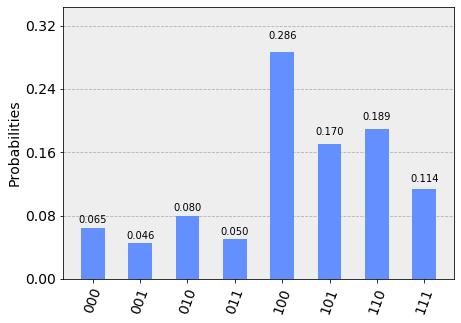

In [18]:
# get the least-busy backend at IBM and run the quantum circuit there
from qiskit.providers.ibmq import least_busy
backend = least_busy(provider.backends(simulator=False))
job_exp = execute(qc, backend=backend, shots=8192)
exp_result = job_exp.result()

exp_measurement_result = exp_result.get_counts(qc)
print(exp_measurement_result)
plot_histogram(exp_measurement_result)

In [12]:
#As we see here, there are a few results that contain the case when  c2=1 
#in a real quantum computer. These arise due to errors in the gates that were applied. 
#Another source of error is the way we're checking for teleportation - we need the series of operators on  
#q2  to be exactly the inverse unitary of those that we applied to  q0  at the beginning.'''

In [21]:
error_rate_percent = sum([exp_measurement_result[result] for result in exp_measurement_result.keys() if result[0]=='0']) \
                    * 100./ sum(list(exp_measurement_result.values()))
print("The experimental error rate : ", error_rate_percent, "%")

The experimental error rate :  24.06005859375 %
